# DHS surface interpolation

In [228]:
import os
import functions
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import rasterio

from rasterio.features import shapes
from shapely.geometry import shape, mapping

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [229]:
from skgstat import Variogram

### Parameters

In [230]:
#Urban surface threshold to clip out urban grids (from 0-30) on the Global Human Settlement Layer (GHSL) by the European Commission

ust = 25 # (o to 30) 0 is a totally unpopulated pixel and 30 is a totally urban pixel
target_indicator = 'mpi' #Name of the indicator form the DHS cluster data to be predicted
country = 'KHM' #Three digit country code
year = 2014 #Year of the dhs survey in use
report = {}

In [231]:
report['Country'] = country

In [232]:
report['DHS survey year'] = year

In [233]:
report['Target Indicator'] = target_indicator

In [234]:
report['Urban-rural threshold'] = ust

### Preparation of Georeferenced DHS Indicator Data

In [235]:
data_folder = 'data'

In [236]:
#Load DHS data
path =  os.path.join(data_folder, country, 'DHS/mpi_khm_dhs14_cot_clust_CI_mis/mpi_khm_dhs14_cot_clust_CI_mis.shp') #Data for 2014
dhs = gpd.read_file(path)
dhs = functions.exclude_zero_coordinates(dhs)
#Store the file's crs and use it as the projects
pcrs = dhs.crs

In [237]:
report['DHS clusters before urban masking'] = dhs.shape[0]

## Selection and Preparation of Geospatial Covariate Layers

In [238]:
# Load the shape file with geographic covariates
initial_shape_path = os.path.join(data_folder, country, 'panel/panel-khm-02082024-v2.shp')
gdf = gpd.read_file(initial_shape_path)
gdf = gdf.to_crs(pcrs)

In [239]:
report['Grids before masking'] = gdf.shape[0]

In [240]:
report['CRS'] = pcrs.name

### Drop urban areas

To identify urban zones we use: 

- Global Human Settlement Layer (GHSL) by the European Commission:
	•	The GHSL produces global maps of urban areas based on satellite imagery and other data.
- We are using: GHS-SMOD
- https://human-settlement.emergency.copernicus.eu/ghs_smod2023.php

In [241]:
#Paths

urban_layer_raster = os.path.join(data_folder, 'Global/GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V2_0/GHS_SMOD_E2030_GLOBE_R2023A_54009_1000_V2_0.tif')
country_bounds = os.path.join(data_folder, country, 'country_boundary/country_bounds.shp')
cropped_urban_layer_raster = 'temp_files/urban_layer.tiff'
report_folder = 'temp_files/report'

#### Create a mask of urban areas

In [242]:
#Crop the global urban areas raster to the area of the Country of interest
functions.raster_clipping(country_bounds, urban_layer_raster, cropped_urban_layer_raster)

Reprojecting shapefile from EPSG:4326 to ESRI:54009


'temp_files/urban_layer.tiff'

In [243]:
urban_mask = functions.generate_urban_mask(cropped_urban_layer_raster, ust, 'temp_files/urban_mask_polygons.shp')

Text(0.5, 1.0, 'Urban areas mask for KHM')

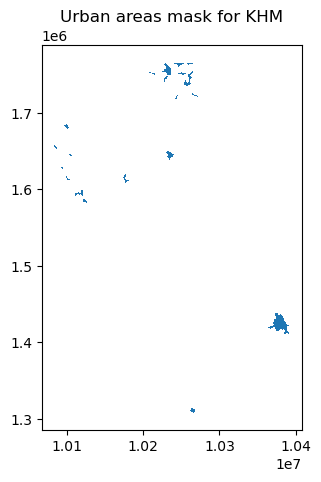

In [244]:
# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))

#Check out the urban mask
title = f"Urban areas mask for {country}"
urban_mask.plot(ax=ax)
ax.set_title(title)

In [245]:
#Clip the urban areas out of the main df
gdf = functions.inverted_clip_touching_gdf(gdf, urban_mask)
dhs = functions.inverted_clip_touching_gdf(dhs, urban_mask)

In [246]:
report['Grids after masking'] = gdf.shape[0]

In [247]:
report['DHS clusters after masking'] = dhs.shape[0]

In [248]:
report

{'Country': 'KHM',
 'DHS survey year': 2014,
 'Target Indicator': 'mpi',
 'Urban-rural threshold': 25,
 'DHS clusters before urban masking': 611,
 'Grids before masking': 7793,
 'CRS': 'WGS 84',
 'Grids after masking': 7667,
 'DHS clusters after masking': 534}

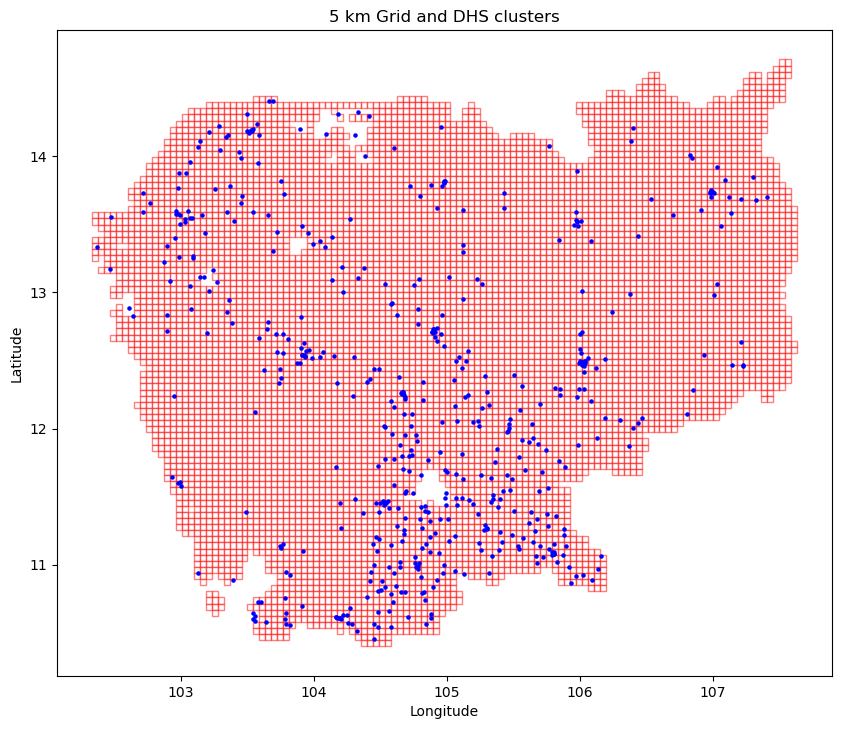

In [249]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame
gdf.plot(ax=ax, facecolor='white', edgecolor='red', alpha=0.5)

# Plot the points on top
dhs.plot(ax=ax, color='blue', markersize=5)

# Customize the plot (optional)
ax.set_title('5 km Grid and DHS clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.savefig(os.path.join(report_folder, '1. Grids - DHS Clusters.png'))

In [250]:
#Create a unique grid ID for later use
#gdf.reset_index(inplace=True)
#gdf.rename({'index':'grid_id'}, axis=1, inplace=True)

### Deal with Multiple Clusters per Grid

- We are averaging each cluster's values in each variable with the other clusters in the grid. It is a gross shortcut, and we will need to review this part. The ideal approach is to go back to the DHS microdata and recalculate averages per grid using the individual data and the cluster IDs.
- However, there are reasons to think that the multiple-clusters-per-grid problem will disappear as the grid resolution becomes finer, so it is not worth spending too much time on this at the moment.


In [251]:
#Join the dhs data to the grids gdf
joined_gdf = gpd.sjoin(dhs, gdf, how='left', predicate='within')

# Group by the index of the grid cells and count the number of points in each cell
point_counts = joined_gdf.groupby('index_right').size()

# Add the point counts to the original grid GeoDataFrame
gdf['point_count'] = gdf.index.map(point_counts).fillna(0).astype(int)

#Number of grids with multiple clusters
t1 = gdf['point_count'].value_counts()
print(t1)

point_count
0    7233
1     392
2      22
3      11
4       4
5       3
6       1
7       1
Name: count, dtype: int64


In [252]:
report['Girds with multiple clusters'] = t1[range(1,7)].sum()

In [253]:
#Identify all the dhs columns plus the grid ID
dhs_variables = dhs.columns.to_list()

#Include the grid ID
dhs_variables.append('grid_id')

In [254]:
#Get the mean of clusters by grid
dhs_averages = pd.concat([joined_gdf[dhs_variables].select_dtypes(include='number'), joined_gdf['grid_id']], axis=1).groupby('grid_id').mean().reset_index()

In [255]:
#Merge the mean of dhs numeric variables back to the orginal grids gdf (only one observation per grid)
gdf = gdf.merge(dhs_averages, on='grid_id', how='left')

### Cleaning the grids gdf

In [256]:
#Drop unnecessary variables
#gdf.drop(['prov_code', 'treat'], axis=1, inplace=True)

In [257]:
dhs_numeric_variables = dhs.select_dtypes(include='number').columns.to_list()
dhs_numeric_variables.remove(target_indicator)

In [258]:
#Keep only the target variable from the dhs set
gdf.drop(dhs_numeric_variables, axis=1, inplace = True)

In [259]:
report['Covariates before filtering'] = gdf.shape[1] - 3

In [260]:
#This steps keeps only covariates on the year and -+1 year
gdf = functions.filter_columns_by_year(gdf, year)

In [261]:
report['Covariates after filtering by -+ 1y'] = gdf.shape[1] - 3

### Dealing with missing values

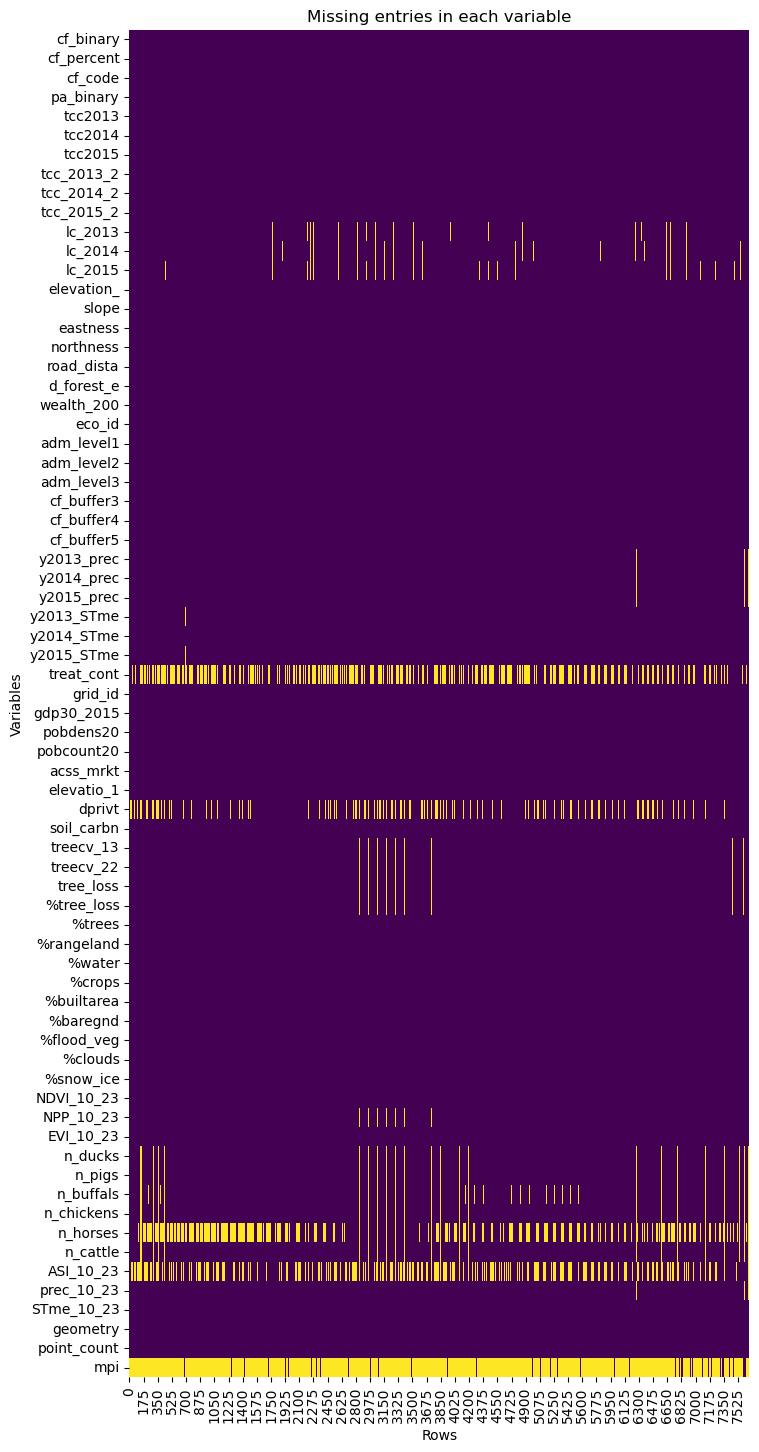

In [262]:
picture_path = os.path.join(report_folder, '2. All covariates missing chart.png')
functions.plot_missing_values_vertical(gdf, picture_path)

In [263]:
# Get a list of columns with null values (except the target variable of course)
columns_with_nulls = gdf.columns[gdf.isnull().any()].tolist()
columns_with_nulls.remove(target_indicator)

In [264]:
#We perform simple interpolation of null values to keep going, but the input data should not have any. 
for column in columns_with_nulls: 
    # Perform IDW interpolation to replace null values
    #gdf = functions.idw_interpolation(gdf, column)
    gdf[column] = gdf[column].fillna(0)

## Exploratory Analysis of target indicator

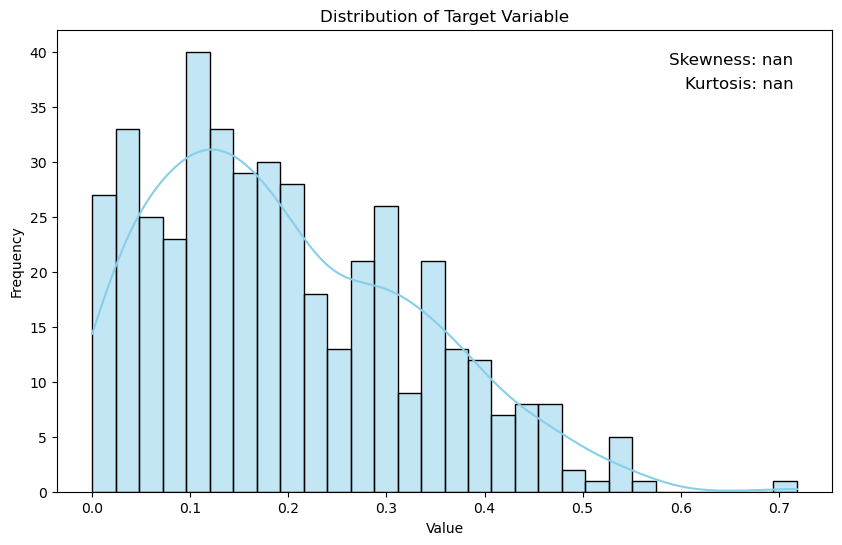

In [265]:
%autoreload
#There are many observations that are close to 0 in the MPI estimation.
picture_path = os.path.join(report_folder, '3. Target Distribution Before Transform.png')
functions.plot_distribution_with_statistics(gdf[target_indicator], picture_path)

In [266]:
t2 = gdf[target_indicator].describe()

In [267]:
print(t2)

count    434.000000
mean       0.196551
std        0.133647
min        0.000000
25%        0.096377
50%        0.173019
75%        0.294033
max        0.718372
Name: mpi, dtype: float64


In [268]:
table_path = os.path.join(report_folder, '5. Target descriptive before transform.html')
pd.DataFrame(t2).to_html(table_path)

### Varioagram for the target variable

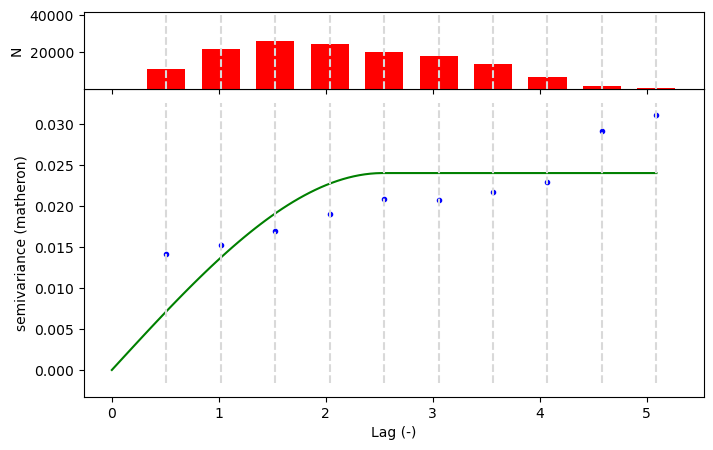

In [269]:
# Extract coordinates from the geometry column
coordinates = [(point.x, point.y) for point in dhs.geometry]
values = dhs[target_indicator].values

# Create and plot the variogram
variogram = Variogram(coordinates, values)
variogram.plot()

picture_path = os.path.join(report_folder, '4. Target Varioagram.png')
plt.savefig(picture_path)
plt.show()

Interpretation of the Variogram:

A variogram describes the spatial continuity or spatial dependence of a variable. Interpretation:

    X-axis (Lag Distance):
        Represents the distance (lag) between pairs of points.
        The distance is normalized in this plot, indicated by "Lag (-)".

    Y-axis (Semivariance):
        Represents the semivariance, which measures the dissimilarity between values as a function of the lag distance.
        The semivariance typically increases with lag distance up to a certain point and then levels off.

    Empirical Semivariance Points (Blue Circles):
        Each blue circle represents the empirical semivariance for a specific lag distance.
        Calculated from the data by averaging the squared differences between all pairs of values separated by that lag distance.

    Fitted Variogram Model (Green Line):
        A model is fitted to the empirical semivariance points.
        The green line represents the theoretical variogram model that best fits the empirical data.

    Histogram of Pair Counts (Red Bars):
        The histogram at the top of the plot shows the number of point pairs used to calculate the semivariance at each lag distance.
        Provides information on the sample size for each lag, with higher bars indicating more pairs.

## Covariate Selection

- We replace the original selection with a Lasso model.
- "The goal was also to identify some variables that were likely to have strong statistical relationships with background environmental factors" (SAR 11) 

### Generate Square and Square-Root Transforms of Covariates

In [306]:
#Two new versions of each of the original 17 covariates were generated: a square and square-root transform yielding 17×3 = 51 candidate covariates. 
# Is this necesary or is it enough to just use Lasso to filter out un necessary variables?

In [307]:
#Exclude non-covariate columns
excluded =['geometry', target_indicator, 'grid_id']

In [308]:
gdf1 = gdf.copy(deep=True)

In [309]:
#Reduce dimensionality temporarily
# Define the percentage of columns to drop so that we keep only 20
#percentage_to_drop = ((gdf1.shape[1] - 100) / gdf1.shape[1]) 

# Calculate the number of columns to drop
#num_cols_to_drop = int(len(gdf1.columns) * percentage_to_drop)

# Randomly select columns to drop
#cols_to_drop = np.random.choice(gdf1.columns, size=num_cols_to_drop, replace=False)

# Drop the selected columns
gdf1 = gdf1.drop(columns=['geometry', 'grid_id', 'point_count'])

In [310]:
# Generate square and square-root transforms
squared_covariates = gdf1**2
sqrt_covariates = np.sqrt(gdf1)

# Combine all covariates into a single DataFrame
gdf2 = pd.concat([gdf1, squared_covariates, sqrt_covariates], axis=1)
gdf2.columns = [f'{col}_orig' for col in gdf1.columns] + \
                         [f'{col}_squared' for col in gdf1.columns] + \
                         [f'{col}_sqrt' for col in gdf1.columns]

In [311]:
#Drop the variables that generated missing values
gdf2 = gdf2.dropna(axis=1, how='any')

In [312]:
report['Covariates after square and square-root transforms'] = gdf2.shape[1]

### Generate pair-wise interactions between covariates

In [277]:
from itertools import combinations

In [278]:
# Generate all pair-wise interaction terms and collect them in a dictionary

interaction_terms = {}
for (col1, col2) in combinations(gdf2.columns, 2):
    interaction_terms[f'{col1}_x_{col2}'] = gdf2[col1] * gdf2[col2]

# Convert the dictionary to a DataFrame and concatenate with the original covariates
interaction_terms_df = pd.DataFrame(interaction_terms)

# Combine the covariates with the interaction terms
gdf3 = pd.concat([gdf2, interaction_terms_df], axis=1)


In [304]:
report['Covariates after pairwise interactions'] = gdf3.shape[1]

In [280]:
#This avoids the pairwise interactions to reduce dimensionality
gdf3 = gdf2.copy(deep=True)

In [281]:
gdf3.shape

(7667, 188)

### Covariates selection

### Lasso

By using Lasso regression, we can directly perform feature selection and build the multivariate model in a single step, thus simplifying the process significantly:

-   Fit Lasso model to select features and build the model (Steps 2, 4, and 5 combined)

This approach leverages Lasso's ability to handle feature selection and regularization, saving time and computational effort while ensuring an interpretable and efficient model.

In [282]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import r2_score
from scipy.stats import skew, kurtosis, boxcox

In [283]:
gdf4 = gdf[[target_indicator]].merge(gdf3, left_index=True, right_index=True, how='left')

In [284]:
#Keep only the observations that have a valid MPI cluster observation
gdf4 = gdf4[~gdf4[target_indicator].isnull()]

In [285]:
target = gdf4[target_indicator]

### Select the best transformation

We use Skwedness and Kurtosis criteria to select the best techinque. Strategy for Selection:

-   High Positive Skew: Apply log or square root transformation.
-   High Negative Skew: Apply square transformation (squaring the data can sometimes help with negative skew).
-   Moderate Skew: Apply Box-Cox or Yeo-Johnson transformation.
-   Low Skew and Kurtosis: No transformation or minimal transformation.

In [286]:
y = pd.Series(target)

In [287]:
# Select and apply the best transformation
target_transformed = functions.select_transformation(y)

Skewness: 0.6360737411099507, Kurtosis: -0.14709569687588697
Applying square root transformation due to moderate positive skewness and non-positive values.


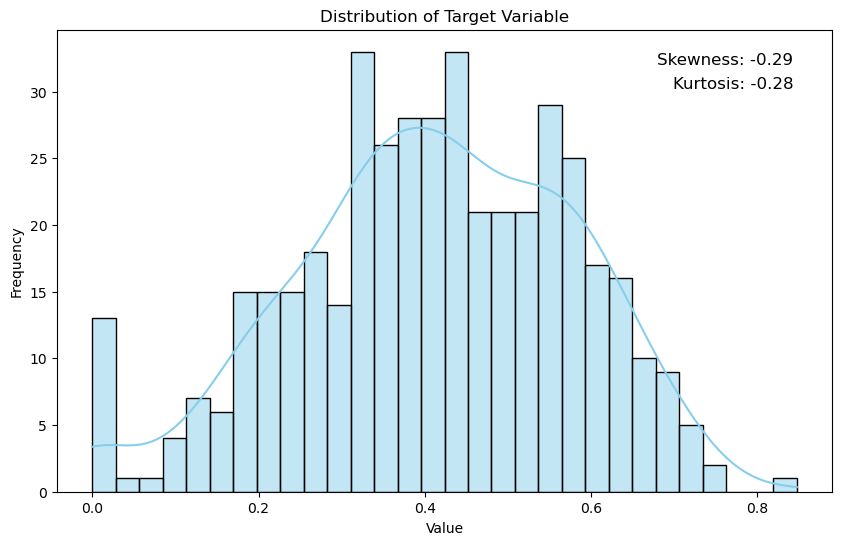

In [288]:
picture_path = os.path.join(report_folder, '6. Target transformed.png')
functions.plot_distribution_with_statistics(target_transformed, picture_path)

In [289]:
t3 = target_transformed.describe()

In [290]:
print(t3)

count    434.000000
mean       0.410855
std        0.166771
min        0.000000
25%        0.310446
50%        0.415955
75%        0.542248
max        0.847568
Name: mpi, dtype: float64


In [291]:
table_path = os.path.join(report_folder, '7. Target descriptive after transform.html')
pd.DataFrame(t3).to_html(table_path)

### Select covariates

In [292]:
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gdf4.drop([target_indicator, ], axis=1), target_transformed, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Fit Lasso model with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=1000).fit(X_train_scaled, y_train_scaled)

# Get the selected features (non-zero coefficients)
selected_features = X_train.columns[(lasso.coef_ != 0)]

In [293]:
print(f'{selected_features.shape[0]} variables were selected as covariates to pass on to the Bayesian model.')

8 variables were selected as covariates to pass on to the Bayesian model.


In [294]:
report['Covariates selected after Lasso'] = selected_features.shape[0]

In [295]:
#Generate the final df with the mpi for export
gdf4 = pd.concat([gdf[[target_indicator, 'geometry', 'grid_id']], gdf3[selected_features]], axis = 1)

In [296]:
picture_path = os.path.join(report_folder,'8. Final database chart.png')

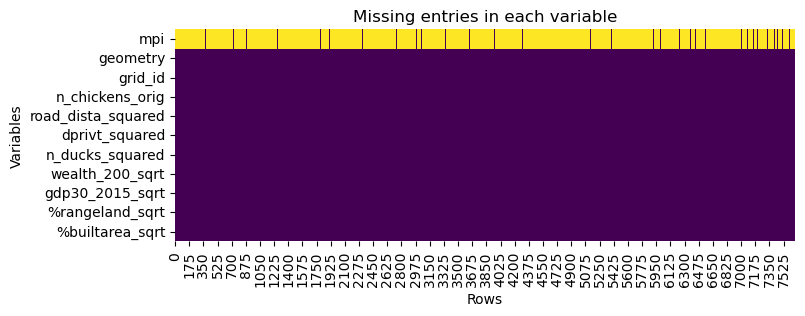

In [297]:
functions.plot_missing_values_vertical(gdf4, picture_path)

### Save objects for MBG

In [298]:
#Temporarily reduce dimensionality 
gdf4 = gdf4.sample(2000)
gdf4.shape

(2000, 11)

In [299]:
#Save the df with selected features and with target variable
pd.DataFrame(gdf4.drop('geometry', axis=1)).to_pickle('temp_files/selected_features.pkl')

In [300]:
# Extract coordinates from the geometry column (using centroid for Polygons)
coordinates = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf4.geometry])

# Save coordinates as a pickle file
with open('temp_files/coordinates.pkl', 'wb') as f:
    pickle.dump(coordinates, f)

# Extract coordinates from the geometry column (using centroid for Polygons) only for observed rows
coordinates_observed = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf4[~gdf4[target_indicator].isnull()].geometry])

# Save coordinates as a pickle file
with open('temp_files/coordinates_observed.pkl', 'wb') as f:
    pickle.dump(coordinates_observed, f)

# Extract coordinates from the geometry column (using centroid for Polygons) only for unobserved rows
coordinates_unobserved = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf4[gdf4[target_indicator].isnull()].geometry])

# Save coordinates as a pickle file
with open('temp_files/coordinates_unobserved.pkl', 'wb') as f:
    pickle.dump(coordinates_unobserved, f)

In [330]:
t4 = pd.DataFrame(data={'Data':report.keys(), 
                  'Value': report.values()}, 
             columns=['Data','Value'])

In [331]:
table_path = os.path.join(report_folder, '8. Covariates Report.html')
pd.DataFrame(t4).to_html(table_path)

## Geostatistical Modeling

This part is done in the 3. Bayesian MBG estimation Notebook.